# Reward Function Validation - Progress with Time Penalty

Reward functions can easily get complex to visualize once it starts taking a number of factors into account.  This notebook will help with a quick validation by running it over the track and a number of 

In [2]:
# Load the track to exercise
from math import log
#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline


Waypoints shape: (203, 6)
Centerline length: 21.74
Track bounds:  (0.5871459377974991, -3.1185757246211283, 9.349370097060229, 3.0140815800413567)
[4.60918546 1.6430465  4.58646449 1.30659668 4.63079245 1.97884398]
Track width:  0.6737072087508159


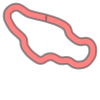

In [3]:

TRACK_NAME = 'Canada_Training'

# Helper functions


# Visualize the Track and Waypoints

# Tracks Available::
# AWS_track                Straight_track                Oval_track
# Bowtie_track             H_track                       reinvent_base
# China_track              Mexico_track                  Canada_training

waypoints = np.load("tracks/%s.npy" % TRACK_NAME)
print("Waypoints shape: {}".format(waypoints.shape))

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(waypoints[:,0:2])
l_inner_border = LineString(waypoints[:,2:4])
l_outer_border = LineString(waypoints[:,4:6])
road_poly = Polygon(np.vstack((l_outer_border, np.flipud(l_inner_border))))

# Print some useful track analysis data
print("Centerline length: %0.2f" % l_center_line.length)
print("Track bounds: ", road_poly.bounds)
print(waypoints[0])
print("Track width: ", np.linalg.norm(waypoints[0,4:6] - waypoints[0,2:4]))
#print("Track y min/max: ", pd.DataFrame(outer_border)['y'])
road_poly


Text(4.817766904830933, 1.5820860266685486, '200')

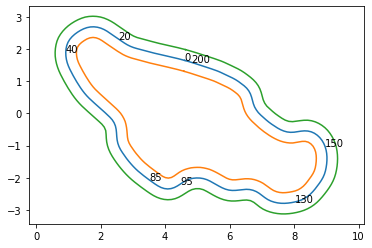

In [4]:
# scan the track and invoke the reward function for each waypoint

# Sections of Canada_Training
plt.plot(center_line[:,0:1], center_line[:,1:2])
plt.plot(inner_border[:,0:1], inner_border[:,1:2])
plt.plot(outer_border[:,0:1], outer_border[:,1:2])
plt.axis('equal')
plt.annotate('0', center_line[0])
# Straight
plt.annotate('20', center_line[20])
# Sharp left
plt.annotate('40', center_line[40])
# Straight
plt.annotate('85', center_line[85])
# Easy left
plt.annotate('95', center_line[95])
# Straight
plt.annotate('130', center_line[130])
# Easy left
plt.annotate('150', center_line[150])
# Straight
plt.annotate('200', center_line[200])

# Reward function code here

In [72]:
"""
AWS DeepRacer reward function using sparse rewards
"""
# CONSTANTS
TARGET_STEPS = 100        # budget of steps we want to complete the course
NEON_PROGRESS_CHECKPOINTS = [
    0,
    10,
    20,
    32,
    40,
    50,
    63,
    73,
    83,
    91,
    100,
    10000
]

#PROGRESS_CHECKPOINTS = [  # Hand-picked checkpoints along the Canada Training track since
#                          # the curvature of the track can skew the checkpoint line and
#                          # cause the car to hunt a bad line
#    0,  # we don't hand out a reward at zero, just here for algorithms
#    6,
#    18,
#    25,
#    33,
#    45,
#    57.5,
#    68,
#    76,
#    87,
#    100,
#    10000
#]
# Use this if the start point has shifted by -4%
PROGRESS_CHECKPOINTS_SHIFTED = [
    0,
    14,
    24,
    36,
    44,
    54,
    67,
    77,
    87,
    95,
    100,
    10000
]

# Globals
g_last_checkpoint_progress = 0.0
g_last_checkpoint_steps = 0

#===============================================================================
#
# REWARD
#
#
# Things that don't work:
#
#  progress_delta / time_delta => leads to exponential rewards as car goes faster
#  progress_delta / progress_total => increased rewards for longer episodes
#
#  progress_delta + 
#===============================================================================

def checkpoint_for_progress(progress):
    for i in range(len(PROGRESS_CHECKPOINTS_SHIFTED)):
        if PROGRESS_CHECKPOINTS_SHIFTED[i] > progress:
            return i-1
    return -1

def reward_function(params):
    # Progress range:  0..100
    # Step is roughly a 1/15s timeslice so can account for time-factor
    # Expected real value: [0,~1.0]
    global g_last_checkpoint_progress
    global g_last_checkpoint_steps

    # Simple reward for outlier case of first step in the episode
    if params['steps'] == 0:
        reward = 1e-3
        g_last_checkpoint_progress = 0
        g_last_checkpoint_steps = 0
    else:
        previous_checkpoint_index = checkpoint_for_progress(g_last_checkpoint_progress)
        current_checkpoint_index = checkpoint_for_progress(params['progress'])
        if previous_checkpoint_index < current_checkpoint_index:
            # passed a checkpoint
            budget_checkpoint_steps = (TARGET_STEPS / 100.0) * (PROGRESS_CHECKPOINTS_SHIFTED[current_checkpoint_index] - PROGRESS_CHECKPOINTS_SHIFTED[previous_checkpoint_index])
            elapsed_checkpoint_steps = (params['steps'] - g_last_checkpoint_steps)
            reward = budget_checkpoint_steps / (params['steps'] - g_last_checkpoint_steps)
            print(params['steps'], g_last_checkpoint_steps, budget_checkpoint_steps, elapsed_checkpoint_steps, reward)
            g_last_checkpoint_progress = params['progress']
            g_last_checkpoint_steps = params['steps']
        else:
            # for incremental progress, small reward for straight
            if params['steering_angle'] == 0:
                reward = 1e-2
            else:
                reward = 1e-3
    return reward

# Test the reward function

In [20]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

def rewards_for_episode(max_progress, nsteps):
    episode_reward = 0.0
    step_rewards = list()
    for i in range(nsteps+1):
        progress = i * (max_progress / nsteps)
        reward = reward_function({'progress': progress, 'steps': i})
        episode_reward += reward
        step_rewards.append((i, progress, reward, episode_reward))
#    return pd.DataFrame(step_rewards, columns=('step', 'progress', 'reward', 'total_reward'))
    return step_rewards

#rewards_for_episode(10,10).tail(1)['total_reward'].values[0]


plot_df = pd.DataFrame(rewards_for_episode(100,150), columns=('step', 'progress', 'reward', 'total_reward'))
plot_df.tail()

# make a plot of rewards
#episode_rewards = list()
#for progress in range(5,105,5):
#    for steps in range(90,160,10):
#        reward = rewards_for_episode(progress,steps)
        #print(reward)
#        episode_rewards.append(reward[-1])

#plot_df = pd.DataFrame(episode_rewards, columns=('step', 'progress', 'reward', 'total_reward'))
#plot_df.head(50)

#fig = plt.figure()
#ax = fig.gca(projection='3d')
# Plot the surface.
#surf = ax.plot_trisurf(plot_df['step'], plot_df['progress'], plot_df['total_reward'], cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

#plt.show()

21 0 28.0 21 1.3333333333333333
42 21 28.0 21 1.3333333333333333
56 42 18.0 14 1.2857142857142858
74 56 24.0 18 1.3333333333333333
93 74 25.0 19 1.3157894736842106
104 93 15.0 11 1.3636363636363635
120 104 22.0 16 1.375
137 120 22.0 17 1.2941176470588236
150 137 18.0 13 1.3846153846153846


,step,progress,reward,total_reward
146,146,97.333333,0.010000,12.015258
147,147,98.000000,0.010000,12.025258
148,148,98.666667,0.010000,12.035258
149,149,99.333333,0.010000,12.045258
150,150,100.000000,1.384615,13.429873


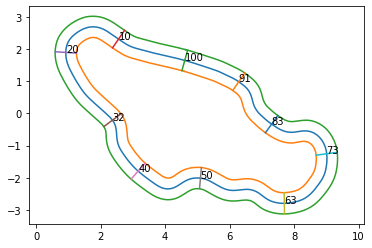

In [71]:
# Plot the checkpoint projections so we know exactly where
# the rewards will be given
plt.plot(center_line[:,0:1], center_line[:,1:2])
plt.plot(inner_border[:,0:1], inner_border[:,1:2])
plt.plot(outer_border[:,0:1], outer_border[:,1:2])
plt.axis('equal')
PROGRESS_CHECKPOINTS = [
#    6,
#    18,
#    25,
#    33,
#    45,
#    57.5,
#    68,
#    76,
#    87,
#    100
    10,
    20,
    32,
    40,
    50,
    63,
    73,
    83,
    91,
    100
]
for p in PROGRESS_CHECKPOINTS:
    i = int((len(outer_border)/100) * p) # interpolate along the points
    center_point = Point(center_line[i])
    inner_point = l_inner_border.interpolate(l_inner_border.project(center_point))
    outer_point = l_outer_border.interpolate(l_outer_border.project(center_point))
    plt.plot((outer_point.x,inner_point.x),(outer_point.y,inner_point.y))
    plt.annotate(str(p), center_line[i])